<a href="https://colab.research.google.com/github/RudkovYaroslav/Advanced_business_analysis/blob/main/Business_analysis_2(A_B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект "Углубленный анализ гипотез"

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

В распоряжении у нас 3 датафрейма:

 - Hypothesis: Датафрейм с кратким описанием гипотез и их характеристики(охват, влияние, уверенность и затраты)
 - Orders: Датафрейм с информацией о заказах
 - Visitors: Датафрейм с информацией о пользователях

Цель исследования:

 - Провести приоритизацию гипотез
 - Проанализировать результаты A/B теста
 - Оценить ошибки и аномалии при проведении A/B теста
 - Оформить выводы по результатам теста

Ход исследования

Я получу данные из датафреймов, которые находятся в трех csv файлах. О качестве этих DataFrame пока ничего не известно, так что, скорее всего, понадобится провести предобработку.

Проверю данные на аномалии и выбросы, которые могут повлиять на исследование, заполню пропуски, если они имеются, и в целом поищу возможность исправить все ошибки, которые не приведут к искажению конечного результата.

Итоговое исследование пройдет в 7 этапов:

 - Обзор данных
 - Предобработка данных
 - Приоритизация гипотез
 - Построение графиков кумулятивных средних
 - Построение точечных графиков для оценки аномалий
 - Расчет статистической значимости
 - Общий вывод

## Обзор данных

Импортируем нужные библиотеки и зададим некоторые стандартные параметры:

In [ ]:
import pandas as pd #Библиотека для обработки DataFrame
import datetime as dt #Библиотека для работы с датами
import matplotlib.pyplot as plt #Библиотека для задачи аттрибутов графиков
from scipy import stats #Библиотека для работы с теорией вероятности
plt.rcParams["figure.figsize"] = (15,5)
from datetime import timedelta #Часть библиотеки datetime
import numpy as np #Библиотека для использования математических функций

In [ ]:
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

Этот код в дальнейшем пригодится(Нужен для вывода таблиц "подряд" по горизонтали, а не вертикали)

Считаем файлы:

In [ ]:
hyp = pd.read_csv('/datasets/hypothesis.csv')
display(hyp.head())
hyp.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [ ]:
orders = pd.read_csv('/datasets/orders.csv')
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [ ]:
visitors = pd.read_csv('/datasets/visitors.csv')
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


## Предобработка данных

При первом взгляде на данные есть несколько вещей, которые нужно поправить:

### Hypothesis

Переименуем колонки в соответствии со стандартом, а также сам датафрейм для более простого написания

In [ ]:
hyp = hyp.rename(columns = {'Hypothesis' : 'hyp', 'Reach' : 'reach',\
                                          'Impact' : 'impact', 'Confidence' : 'confidence', 'Efforts' : 'efforts'})

### Orders

Здесь также необходимо переименовать колонки, но еще и привести дату в правильный формат

In [ ]:
orders = orders.rename(columns = {'transactionId' : 'trans_id', 'visitorId' : 'visitor_id'})

In [ ]:
orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d')

In [ ]:
orders.duplicated().sum()

0

Явных дубликатов не оказалось

### Visitors

Здесь нужно только привести к правильному формату столбец date

In [ ]:
visitors['date'] = pd.to_datetime(visitors['date'], format = '%Y-%m-%d')

In [ ]:
visitors.duplicated().sum()

0

Явных дубликатов здесь также не оказалось

### Вывод по разделу 2

Произвели предобработку данных:
 - Рассмотрели пропуски. По итогу их нигде не оказалось.
 - Переименовали все столбцы для соответствия стандартам
 - Привели все столбцы к правильному типу данных
 - Проверили датафреймы на явные и неявные дубликаты. Их не оказалось

По итогу данные оказались очень хорошими и практически не нуждались в предобработке

## Приоритизация гипотез

Более подробно рассмотрим датафрейм hyp

In [ ]:
hyp

,hyp,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Выведем более подробно:

In [ ]:
pd.set_option('display.max_colwidth', None)
hyp

,hyp,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Приступим к анализу самих показателей. Создадим отдельный DataFrame для хранения данных

In [ ]:
priority_df = pd.DataFrame(columns = ['ICE', 'RICE', 'diff'])

### ICE

Рассчитаем ICE с помощью параметров ICE - Impact, Confidence, (Ease or Efforts)

In [ ]:
priority_df['ICE'] =  round((hyp['impact'] * hyp['confidence']) / hyp['efforts'], 2)

### RICE

Рассчитаем RICE с помощью параметров ICE - Reach, Impact, Confidence, (Ease or Efforts)

In [ ]:
priority_df['RICE'] = round((hyp['impact'] * hyp['confidence'] * hyp['reach']) / hyp['efforts'], 2)

### Diff

Посчитаем разницу между показателями:

In [ ]:
priority_df['diff'] = round(priority_df['RICE'] - priority_df['ICE'], 2)

In [ ]:
display(priority_df.sort_values(by='ICE', ascending=False))
display(priority_df.sort_values(by='RICE', ascending=False))

,ICE,RICE,diff
8,16.20,16.2,0.00
0,13.33,40.0,26.67
7,11.20,112.0,100.80
6,8.00,40.0,32.00
2,7.00,56.0,49.00
1,2.00,4.0,2.00
5,1.33,4.0,2.67
3,1.12,9.0,7.88
4,1.00,3.0,2.00


,ICE,RICE,diff
7,11.20,112.0,100.80
2,7.00,56.0,49.00
0,13.33,40.0,26.67
6,8.00,40.0,32.00
8,16.20,16.2,0.00
3,1.12,9.0,7.88
1,2.00,4.0,2.00
5,1.33,4.0,2.67
4,1.00,3.0,2.00


### Вывод по разделу 3

Создали DataFrame, в котором сравнили фреймворки ICE и RICE. В результате получили примерно похожие данные - в обоих фреймворках в топ-3 по важности входят гипотезы под индексами 7 и 0. Фреймворк RICE является более информативным, так как он учитывает параметр охвата пользователей, который, на самом деле, немаловажен. Просто иногда нет возможности или времени точно оценить это, поэтому и используют ICE, который, в свою очередь, не сильно отстает по результатам.

Если руководствоваться более информативным фреймворком, наиболее важными гипотезами являются:

 - 7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
 - 2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
 - 0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

## Анализ A/B-теста

### Построим график кумулятивной выручки по группам

Для этого нам потребуется:

 - Создать датафрейм с уникальными парами Дата - Группа
 - Создать два датафрейма с уже кумулятивными значениями по выручке и количеству посетителей по дням, а затем их объединить
 - Разделить полученный общий датафрейм по группам
 - Построить график по выручке

In [ ]:
# Датафрейм уникальных пар Дата - Группа
date_groups = orders[['date','group']].drop_duplicates()

In [ ]:
# Создаем датафрейм с агрегированными кумулятивными значениями выручки по дням
orders_aggregated = date_groups.apply(lambda x: \
                                       orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'trans_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [ ]:
# Создаем датафрейм с агрегированными кумулятивными значениями количества посетителей по дням
visitors_aggregated = date_groups.apply(lambda x: \
                                       visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [ ]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'trans_id', 'buyers', 'revenue', 'visitors']

cumulative_data.head(5)

,date,group,trans_id,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [ ]:
cumulative_data['date'].min() == orders['date'].min() and cumulative_data['date'].max() == orders['date'].max() \
and cumulative_data['date'].min() == visitors['date'].min() and cumulative_data['date'].max() == visitors['date'].max()

True

Созданный датафрейм является корректным

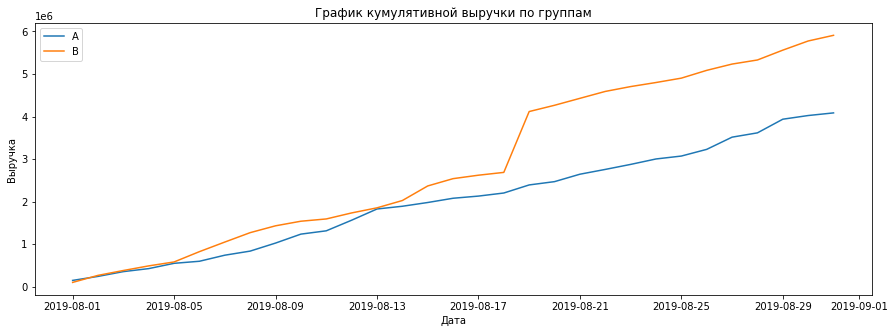

In [ ]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'trans_id']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'trans_id']]

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

#Объединяем их в один и добавляем названия осей
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()
plt.show()

По графику можно сделать первоначальное предположение, что группа B лидирует по выручке, но скачок в районе 18 - 19 сентября немного настораживает

### Построим график кумулятивного среднего чека по группам

Здесь у нас уже есть данные. Необходимо просто привести их в графический вид:

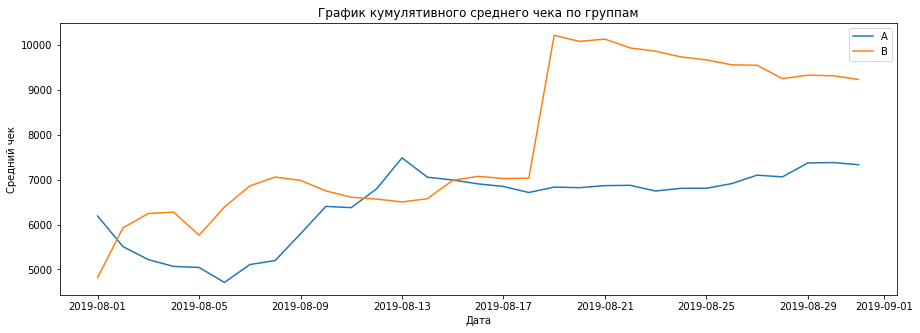

In [ ]:
# Строим график кумулятивного среднего чека группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['trans_id'], label='A')
# Строим график кумулятивного среднего чека группы В
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['trans_id'], label='B')
#Объединяем их в один и добавляем названия осей
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend()
plt.show()

Видим ту же ситуацию, что и ранее. Изначально обе группы находились на одном уровне, но затем 18 - 19 сентября группа В резко взлетела вверх по выручке

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

Для выполнения данного задания нам будет необходимо объединить датафреймы с кумулятивными значениями в один, а затем посчитать средний чек для каждой группы, также относительный средний чек и представить графически

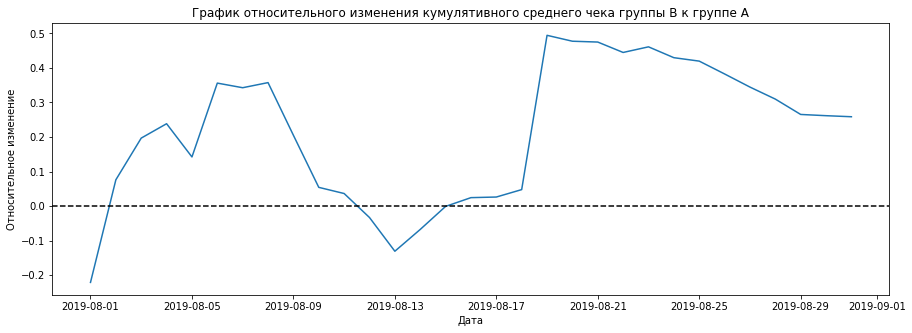

In [ ]:
# Собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

# Строим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['trans_id_b'])/(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['trans_id_a'])-1)

# Добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.show()

По графику видно, что группа B почти всегда опережает группу А по среднему чеку. Даже до скачка 18 - 19 сентября, группа В находилась в лидерах

### Построим график кумулятивного среднего количества заказов на посетителя по группам

Алгоритм таков, что нам предстоит вернуться к датафрейму с общими кумулятивным данными и рассчитать конверсию, а затем прдеставить ее графически для каждой группы

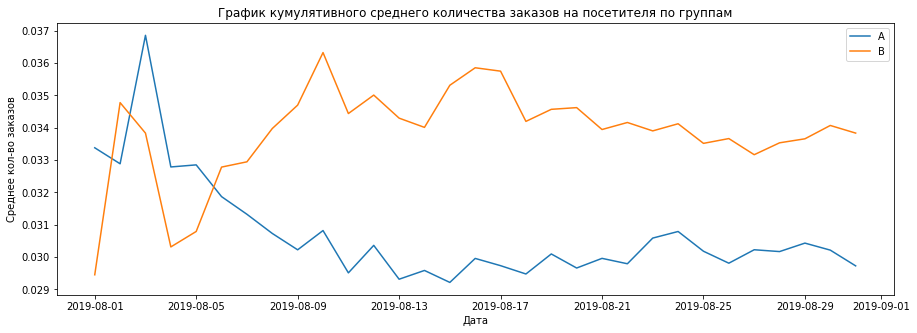

In [ ]:
# Считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['trans_id']/cumulative_data['visitors']

# Отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# Отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# Объединяем их в один график и добавляем названия осей
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее кол-во заказов')
plt.legend()
plt.show()

На этом графике четко видно превосходство группы B в количестве заказов over time. Оба графика практически "закрепились" за 10 дней с начала исследования

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

Для решения этой задачи нам предстоит взять датафреймы из прошлого задания и посчитать относительное значение

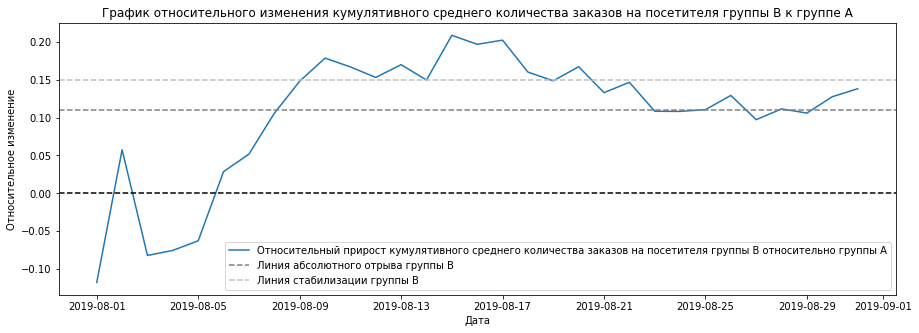

In [ ]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_b']/merged_cumulative_conversions['conversion_a']-1, label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.11, color='grey', linestyle='--', label = 'Линия абсолютного отрыва группы В')
plt.axhline(y=0.15, color='silver', linestyle='--', label = 'Линия стабилизации группы В')#Поставим отметку в 0.11 для наглядности выводов
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.legend()
plt.show()

На данном графике видно, что количество заказов группы В практически всегда было больше, чем в группе А, а на ~10 день уже не опускалось ниже 10 - 11% выше. По итогу группа В стабилизировалась около ометки в ~15%

### Построим точечный график количества заказов по пользователям

Самое время рассмотреть аномалии перед проведением стат тестов. Начнем с количества заказов. Для этого мы сгруппируем датафрейм orders по пользователям и закинем его на точечный график

In [ ]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'trans_id': 'nunique'})
)

orders_by_users.columns = ['visitor_id', 'trans_id']

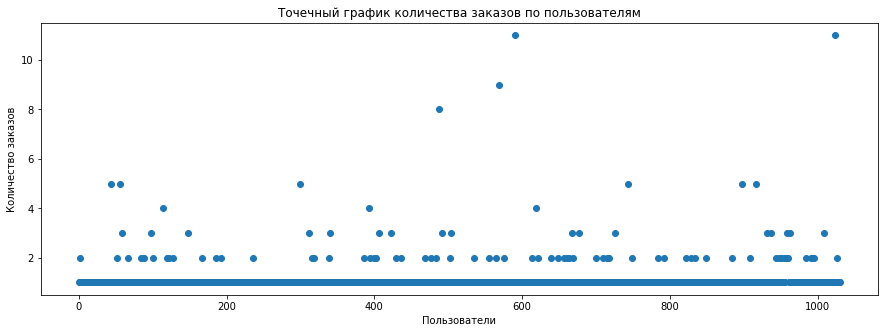

In [ ]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['trans_id'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

В целом даже цифра 2 в количестве заказов - большая редкость, что там дальше говорить о большем количестве. Подавляющее большинство покупателей закупились одноразово.

### Посчитаем перцентили количества заказов на пользователя

In [ ]:
np.percentile(orders_by_users['trans_id'], [95, 99])

array([2., 4.])

Около 95% пользователей заказало меньше 2 заказов(Что примерно было видно на графике), лишь 1% оформил заказ > 4 раз.

Сделаем "аномальный" потолок в 2 заказа, как бы это ни было грустно

### Построим точечный график стоимостей заказов

Аналогично с количеством заказов, проделаем такую же работу:

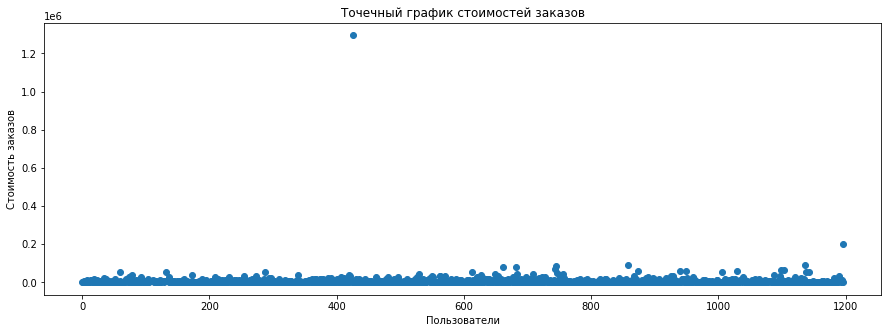

In [ ]:
x_values = pd.Series(range(len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.show()

Цифра в ~1.3 миллиона сильно портит картину, почти ничего не видно

In [ ]:
normal_orders = orders[orders['revenue'] < 1000000]

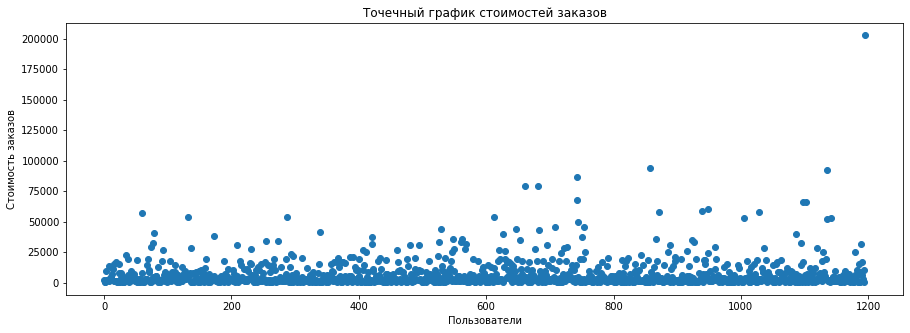

In [ ]:
x_values = pd.Series(range(len(normal_orders['revenue'])))
plt.scatter(x_values, normal_orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
plt.show()

Теперь видно больше. Средний заказ находится на пороге около 25000. Для определения этого порога посмортрим на процентили в следующем разделе.

### Посчитаем перцентили стоимости заказов

In [ ]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Как я и думал, граница, за которой находятся 95% пользователей - это заказ на сумму меньше 28000 - ее и оставим, как "аномальный" потолок

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Для подсчета стат значимости необходимо будет реализовать следующие шаги:

 - Посчтитать количество заказов по пользователям групп
 - Посчитатть количество заказов по датам групп
 - Взять кумулятивные значения из датафрейма, который мы создали ранее
 - Объединить все в один датафрейм

In [ ]:
#Считаем количество заказов по пользователям группы А
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'trans_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'trans_id']

In [ ]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

In [ ]:
#Считаем количество заказов по пользователям группы В
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'trans_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'trans_id']

In [ ]:
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

In [ ]:
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'trans_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'trans_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_a']

In [ ]:
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'trans_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'trans_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

In [ ]:
# Объединяем все в один датафрейм
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(cumulative_data_a[['date', 'trans_id', 'revenue', 'visitors']], left_on='date', right_on='date', how='left', suffixes=['_b', '_a'])
    .merge(cumulative_data_b[['date', 'trans_id', 'revenue', 'visitors']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
)

data = data.rename(columns = {'trans_id_a' : 'orders_cummulative_a', 'revenue_a' : 'revenue_cummulative_a',\
                                'visitors_a' : 'visitors_cummulative_a','trans_id_b' : 'orders_cummulative_b',\
                                'revenue_b' : 'revenue_cummulative_b', 'visitors_b' : 'visitors_cummulative_b' })
print(data.head(5))

        date  orders_per_date_b_x  revenue_per_date_a  orders_per_date_b_y  \
0 2019-08-01                   24              148579                   21   
1 2019-08-02                   20               93822                   24   
2 2019-08-03                   24              112473                   16   
3 2019-08-04                   16               70825                   17   
4 2019-08-05                   25              124218                   23   

   revenue_per_date_b  orders_cummulative_a  revenue_cummulative_a  \
0              101217                    24                 148579   
1              165531                    44                 242401   
2              114248                    68                 354874   
3              108571                    84                 425699   
4               92428                   109                 549917   

   visitors_cummulative_a  orders_cummulative_b  revenue_cummulative_b  \
0                     719           

С этим закончили, теперь необходимо создать два столбца с пользователями и количеством заказов по группам, и затем уже рассчитать p-value

Также перед этим стоит выдвинуть интересующую нас гипотезу, по которой будем рассчитывать p-value:

$H_0$ - нет существенной разницы между средним количеством заказов двух групп, используя "сырые" данные

$H_1$ - между двумя группами есть существенная разница в среднем количестве заказов, используя "сырые" данные

Тест будем проводить с выбранным aplha = 0.05. Тест будет U-тест Манна-Уитни, так как обычный t-test нам не подойдет. Много шума и данные не распределены нормально, а также у нас не совсем одинаковое количество посетителей

In [ ]:
print('Количество посетителей группы А =', visitors[visitors['group'] == 'A']['visitors'].sum())
print('Количество посетителей группы B =', visitors[visitors['group'] == 'B']['visitors'].sum())

Количество посетителей группы А = 18736
Количество посетителей группы B = 18916


In [ ]:
# Создаем Series в котором у каждого пользователя группы А будет количество заказов(Даже если оно равно 0)
sample_a = pd.concat(
    [orders_by_users_a['trans_id'], pd.Series(0, \
    index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['trans_id'])), name='trans_id')], axis=0)

# Создаем Series в котором у каждого пользователя группы В будет количество заказов(Даже если оно равно 0)
sample_b = pd.concat(
    [orders_by_users_b['trans_id'], pd.Series(0, \
    index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['trans_id'])), name='trans_id')], axis=0)

print('p-value =', "{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('Относительный прирост среднего числа заказов группы B =',"{:.2%}".format(sample_b.mean() / sample_a.mean() - 1))


p-value = 0.017
Относительный прирост среднего числа заказов группы B = 13.81%


p-value меньше, чем alpha, который мы выбрали равным 0.05, следовательно, можем отвергнуть нулевую гипотезу о том, что между этими групами нет разницы. Все же они разные и относительный прирост об этом как раз говорит. Группа B в среднем имеет на 14% больше количество заказов, чем группа А по "сырым" даным

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Аналогично с предыдущим заданием, все у нас уже есть на руках, осталось только сформировать гипотезы и провести тест:

$H_0$ - нет существенной разницы между средним чеком заказа двух групп, используя "сырые" данные

$H_1$ - между двумя группами есть существенная разница в среднем чеке заказа , используя "сырые" данные

Также, как и раньше будем проводить тест методом Манна-Уитни с aplha = 0.05

In [ ]:
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост средней суммы чека группы B =', '{:.2%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.729
Относительный прирост средней суммы чека группы B = 25.87%


Вот здесь перед нами уже интересная картина. p-value в разы больше alpha = 0.05, что говорит о том, что мы не можем отвергнуть нулевую гипотезу о том, что средние чеки двух групп равны, вот только если посмотерть на относительный прирост, то в группе В, в среднем, чек на целых 26% больше! Возможно, сказывается влияние выбросов, так что нужно это обязательно проверить

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Проделаем те же самые шаги, что и в двух заданиях ранее, только сперва очистим датафреймы, используя потолки, о которых говорили ранее:

In [ ]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['trans_id'] > np.percentile(orders_by_users['trans_id'], 95)]['visitor_id'],
        orders_by_users_b[orders_by_users_b['trans_id'] > np.percentile(orders_by_users['trans_id'], 95)]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5))
abnormal_users.shape[0]

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64

74

Вышло 74 аномальных значения

In [ ]:
# Создаем Series в котором у каждого пользователя группы А будет количество заказов(Даже если оно равно 0)
sample_a_filtered = pd.concat(
    [orders_by_users_a[np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))]['trans_id'], pd.Series(0, \
    index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['trans_id'])), name='trans_id')], axis=0)

# Создаем Series в котором у каждого пользователя группы В будет количество заказов(Даже если оно равно 0)
sample_b_filtered = pd.concat(
    [orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))]['trans_id'], pd.Series(0, \
    index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['trans_id'])), name='trans_id')], axis=0)

Также рассмотрим гипотезы перед проведением теста:

$H_0$ - нет существенной разницы между средним количеством заказов двух групп, используя "чистые" данные

$H_1$ - между двумя группами есть существенная разница в среднем количестве заказов, используя "чистые" данные

Также, как и раньше будем проводить тест методом Манна-Уитни с aplha = 0.05

In [ ]:
print('p-value =','{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Относительный прирост среднего числа заказов группы B в очищенном датафрейме =', '{:.2%}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

p-value = 0.013
Относительный прирост среднего числа заказов группы B в очищенном датафрейме = 17.27%


Показатель p-value практически не изменился, а относительный прирост увеличился. Также, как и в прошлый раз, можем отвергнуть нулевую гипотезу о том, что между этими групами нет разницы. Все же теперь можем смело говорить, что группы не похожи по количеству заказов - в группе B их больше на почти 17%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Проделаем уже знакомые вычисления по уже полученным "чистым" данным, но, сперва, гипотезы:

$H_0$ - нет существенной разницы между средним чеком заказа двух групп, используя "чистые" данные

$H_1$ - между двумя группами есть существенная разница в среднем чеке заказа , используя "чистые" данные

Также, как и раньше будем проводить тест методом Манна-Уитни с aplha = 0.05

In [ ]:
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
                                                       orders[np.logical_and( orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']).pvalue))

print('Относительный прирост средней суммы чека группы B в очищенном датафрейме =', "{:.2%}".format(
        orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()/
        orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()- 1))

p-value = 0.738
Относительный прирост средней суммы чека группы B в очищенном датафрейме = -1.96%


Финальный тест показывает p-value, который невероятно больше aplha = 0.05, что говорит нам о том, что мы никак не можем отвергнуть нулевую гипотезу и все же, скорее средние чеки равны, чем нет. Причем и относительный прирост подтверждает - группа В отстает от группы А всего на ~2%.

### Выводы по разделу 4

На основании полученых резульаттов можно прийти в решению __остановить тест и зафиксировать победу одной из групп - группы В__. Для такого вывода руководствовались следующими фактами:

 - Графики кумулятивного количества заказов и среднего чека подтверждают выдивнутый вывод. Группа В почти всегда опережает конкурента по этим показателям
 - Если рассматривать стат тесты, то средний чек находится на примерно равном уровне у обеих групп, но если мы берем во внимание "сырые" данные, то там ситуация куда выгоднее для группы В - средний чек больше почти на четверть
 - Даже в "очищенном" датафрейме среднее количество заказов у группы В больше на ~17%
 - A/B тест проходит уже месяц и мы можем видеть стагнацию в позициях групп, особенно на графиках. Продолжать не имеет смысла

## Общий вывод

__Вывод:__

 - __1. Подготовка датафреймов -__ Импортировали нужные библиотеки, создали 3 DataFrame из csv файлов.
 - __2. Предобработка данных -__ Данные оказались очень хорошими и практически не нуждались в предобработке, но все же вот шаги, которые провели:
   - Рассмотрели пропуски. По итогу их нигде не оказалось.
   - Переименовали все столбцы для соответствия стандартам
   - Привели все столбцы к правильному типу данных
   - Проверили датафреймы на явные и неявные дубликаты. Их не оказалось
 - __3. Приоритизация гипотез -__ Создали DataFrame, в котором сравнили фреймворки ICE и RICE. В результате получили примерно похожие данные. Если руководствоваться более информативным фреймворком, наиболее важными гипотезами являются 7, 2, 0
 - __4. Анализ A/B теста -__ Провели глубокий анализ А/B теста, в ходе которого:
   - Построили графики кумулятивной выручки и среднего чека по группам. Увидели, что группа В сильно лидирует по данным параметрам, также удостоверились в этом, построив относительный график среднего чека. Результат оказался таким же. Большее количество времени средний кумулятивный чек группы В был на 10% выше, чем у группы А, иногда доходив до отметки в 50%
   - Проделали такие же действия с кумулятивным средним количеством заказов на посетителя. По этому параметру группа В также опережает своего конкурента. На относительном графике можно выделить цифру в ~11% в пользу группы В. По итогу группа В стабилизировалась около ометки в ~15%
   - Рассмотрели аномальные значения в обеих группах по среднему чеку и количеству заказов и установили пороговые значения в 2 заказа и 28000 руб. среднего чека для того, чтобы в дальнейшем убрать все значения, выше потолоков
   - Провели стат тесты сначала на "сырых" данных. Получили следующие результаты:
     - Мы отвергли нулевую гипотезу о том, что между групами нет разницы в количестве заказов. С большим шансом, среднее количество находится на разном уровне. Относительный прирост подтверждает данный вывод. Группа B в среднем имеет на 14% больше количество заказов, чем группа А
     - Не смогли отвергнуть нулевую гипотезу о том, что средние чеки двух групп равны. Велика вероятность того, что они находятся на одном уровне. Но если посмотерть на относительный прирост, то в группе В, в среднем, чек на целых 26% больше! Возможно, сказывается влияние выбросов.
   - Затем убрали аномальные значения, используя потолки, которые нашли выше, и провели стат тесты уже на "чистых" данных. Получили следующие результаты:
     - Снова отвергли нулевую гипотезу о том, что между групами нет разницы в количестве заказов. Все же теперь можем смело говорить, что группы не похожи по количеству заказов - в группе B их больше на почти 17%
     - Нникак не смогли отвергнуть нулевую гипотезу о том, что средние чеки разные, так что, скорее средние чеки равны, чем нет. Причем и относительный прирост подтверждает - группа В отстает от группы А всего на ~2%.
 - __5. Общее заключение -__ На основании полученных результатов пришли к решению __остановить тест и зафиксировать победу одной из групп - группы В__, руководствуясь следующими выводами:
   - Графики кумулятивного количества заказов и среднего чека подтверждают выдивнутый вывод. Группа В почти всегда опережает конкурента по этим показателям
   - Если рассматривать стат тесты, то средний чек находится на примерно равном уровне у обеих групп, но если мы берем во внимание "сырые" данные, то там ситуация куда выгоднее для группы В - средний чек больше почти на четверть
   - Даже в "очищенном" датафрейме среднее количество заказов у группы В больше на ~17%
   - A/B тест проходит уже месяц и мы можем видеть стагнацию в позициях групп, особенно на графиках. Продолжать не имеет смысла